In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression

In [2]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css

Using TensorFlow backend.


In [3]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [4]:
! ls /nfs/kitzman2/jacob/proj/jensplice/refs

jkp815_andcoli.contiglengths.txt  jkp815_andcoli.fa.amb  jkp815_andcoli.fa.dict
jkp815_andcoli.dict		  jkp815_andcoli.fa.ann  jkp815_andcoli.fa.pac
jkp815_andcoli.fa		  jkp815_andcoli.fa.bwt  jkp815_andcoli.fa.sa


In [5]:
wt1_refseq = pp.get_refseq( '/nfs/kitzman2/jacob/proj/jensplice/refs/jkp815_andcoli.fa' )[ 0 ]

In [6]:
sa_files = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220406_wt1_subasm/sapipe/sa/*.haps.final.txt

In [7]:
sa_files

['/nfs/kitzman2/jacob/proj/jensplice/20220406_wt1_subasm/sapipe/sa/JKP1053.haps.final.txt',
 '/nfs/kitzman2/jacob/proj/jensplice/20220406_wt1_subasm/sapipe/sa/JKP1054.haps.final.txt',
 '/nfs/kitzman2/jacob/proj/jensplice/20220406_wt1_subasm/sapipe/sa/JKP1055.haps.final.txt']

In [8]:
sa_file_d = { file.split( '/' )[ -1 ].split( '.' )[ 0 ] : pd.read_table( file ) for file in sa_files }

In [9]:
sa_file_d[ 'JKP1054' ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,nbp_ge_11,nbp_ge_12,nbp_ge_13,nbp_ge_14,nbp_ge_15,nbp_ge_16,nbp_ge_17,nbp_ge_18,nbp_ge_19,nbp_ge_20
0,TTGGATATTGATTGGGTGGATGG,True,jkp815,pass,1,jkp815:1234:A:G,0.818182,-1.000000,36,-1,...,198,198,198,198,198,198,198,198,198,198
1,TTGGAGAGTGATTGAGGAGGTGG,True,jkp815,apparently_wt_no_passing_vars,0,NaN,0.162907,-1.000000,65,-1,...,198,198,198,198,198,198,198,198,198,198
2,TTGGATCCGATGGGCTTTTATGG,True,jkp815,pass,1,jkp815:1274:A:G,0.773585,0.212121,41,7,...,198,198,198,198,198,198,198,195,179,130
3,TTGGAGTAGAGTGTTCATAGTGG,True,jkp815,apparently_wt_no_passing_vars,0,NaN,0.198413,0.178571,50,45,...,198,198,198,198,198,198,198,198,198,198
4,TTGGAGGGGGTGAAACAACATGG,True,jkp815,pass,1,jkp815:1364:G:A,0.636364,-1.000000,14,-1,...,198,198,197,188,130,130,130,130,130,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214447,GTTAGTAGTGATGTTGGCCGTGG,True,jkp815,pass,2,"jkp815:1206:T:A,jkp815:1350:G:T",0.769231,0.750000,20,18,...,198,198,198,198,198,198,198,198,198,198
214448,GTTAGGATATAAGCGAGATTTGG,True,jkp815,apparently_wt_no_passing_vars,0,NaN,0.220077,0.240876,57,33,...,199,199,199,199,199,199,199,199,199,199
214449,GTTAGGTATCGGTTTATATTTGG,True,jkp815,pass,2,"jkp815:1281:CAG:CG,jkp815:1392:T:A",0.666667,0.612903,38,19,...,199,199,199,199,199,199,199,199,199,199
214450,GTTAGTACTAGTACCGGCGATGG,True,jkp815,pass,2,"jkp815:1166:G:A,jkp815:1260:C:A",0.783784,1.000000,29,1,...,198,198,198,198,198,198,198,198,198,198


In [10]:
sa_snvs = { name: tbl.loc[ tbl.n_variants_passing == 1 ].copy() for name,tbl in sa_file_d.items() }

In [11]:
sa_snvs[ 'JKP1054' ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,nbp_ge_11,nbp_ge_12,nbp_ge_13,nbp_ge_14,nbp_ge_15,nbp_ge_16,nbp_ge_17,nbp_ge_18,nbp_ge_19,nbp_ge_20
0,TTGGATATTGATTGGGTGGATGG,True,jkp815,pass,1,jkp815:1234:A:G,0.818182,-1.000000,36,-1,...,198,198,198,198,198,198,198,198,198,198
2,TTGGATCCGATGGGCTTTTATGG,True,jkp815,pass,1,jkp815:1274:A:G,0.773585,0.212121,41,7,...,198,198,198,198,198,198,198,195,179,130
4,TTGGAGGGGGTGAAACAACATGG,True,jkp815,pass,1,jkp815:1364:G:A,0.636364,-1.000000,14,-1,...,198,198,197,188,130,130,130,130,130,130
8,TTGGAGTTTATTTGCTTAGTTGG,True,jkp815,pass,1,jkp815:1288:A:C,0.793103,-1.000000,46,-1,...,198,198,198,198,198,198,198,198,198,198
14,TTGGACAGTTTATTTAGTGATGG,True,jkp815,pass,1,jkp815:1228:A:G,0.826087,-1.000000,19,-1,...,198,198,198,198,198,198,198,198,198,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214433,GTTAGGGGCCTTAAAATCAGTGG,True,jkp815,pass,1,jkp815:1283:G:A,0.765957,-1.000000,36,-1,...,198,198,198,198,198,198,198,198,192,170
214435,GTTAGTAGGTCAGGTGGGGTTGG,True,jkp815,pass,1,jkp815:1369:C:G,0.750000,-1.000000,21,-1,...,198,198,198,198,198,198,198,198,198,198
214436,GTTAGTACGGCTTACTAGTTTGG,True,jkp815,pass,1,jkp815:1385:T:C,0.607477,-1.000000,65,-1,...,198,198,198,198,198,198,198,198,198,198
214439,GTTAGTATCTTAATGCCTCATGG,True,jkp815,pass,1,jkp815:1240:G:T,0.885714,-1.000000,31,-1,...,198,198,198,198,198,198,198,198,198,198


In [12]:
sa_snvs = { name: tbl[ [ col for col in tbl if not col.startswith( 'nbp_' ) ] ].copy() for name,tbl in sa_snvs.items() }

In [13]:
sa_snvs[ 'JKP1054' ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,reads_in,reads_used,ref_target_length,minbq,mean_cvg
0,TTGGATATTGATTGGGTGGATGG,True,jkp815,pass,1,jkp815:1234:A:G,0.818182,-1.000000,36,-1,80,80,6329,20,1.630115
2,TTGGATCCGATGGGCTTTTATGG,True,jkp815,pass,1,jkp815:1274:A:G,0.773585,0.212121,41,7,53,53,6329,20,1.085796
4,TTGGAGGGGGTGAAACAACATGG,True,jkp815,pass,1,jkp815:1364:G:A,0.636364,-1.000000,14,-1,36,36,6329,20,0.734397
8,TTGGAGTTTATTTGCTTAGTTGG,True,jkp815,pass,1,jkp815:1288:A:C,0.793103,-1.000000,46,-1,59,59,6329,20,1.211566
14,TTGGACAGTTTATTTAGTGATGG,True,jkp815,pass,1,jkp815:1228:A:G,0.826087,-1.000000,19,-1,51,51,6329,20,1.041239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214433,GTTAGGGGCCTTAAAATCAGTGG,True,jkp815,pass,1,jkp815:1283:G:A,0.765957,-1.000000,36,-1,47,47,6329,20,0.952283
214435,GTTAGTAGGTCAGGTGGGGTTGG,True,jkp815,pass,1,jkp815:1369:C:G,0.750000,-1.000000,21,-1,53,53,6329,20,1.087376
214436,GTTAGTACGGCTTACTAGTTTGG,True,jkp815,pass,1,jkp815:1385:T:C,0.607477,-1.000000,65,-1,229,228,6329,20,4.647812
214439,GTTAGTATCTTAATGCCTCATGG,True,jkp815,pass,1,jkp815:1240:G:T,0.885714,-1.000000,31,-1,64,64,6329,20,1.296887


In [14]:
for tbl in sa_snvs.values():
    
    tbl[ 'pos' ] = [ int( var.split( ':' )[ 1 ] ) for var in tbl.variant_list ]
    tbl[ 'ref' ] = [ var.split( ':' )[ 2 ] for var in tbl.variant_list ]
    tbl[ 'alt' ] = [ var.split( ':' )[ 3 ] for var in tbl.variant_list ]

In [15]:
sa_snvs[ 'JKP1054' ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,reads_in,reads_used,ref_target_length,minbq,mean_cvg,pos,ref,alt
0,TTGGATATTGATTGGGTGGATGG,True,jkp815,pass,1,jkp815:1234:A:G,0.818182,-1.000000,36,-1,80,80,6329,20,1.630115,1234,A,G
2,TTGGATCCGATGGGCTTTTATGG,True,jkp815,pass,1,jkp815:1274:A:G,0.773585,0.212121,41,7,53,53,6329,20,1.085796,1274,A,G
4,TTGGAGGGGGTGAAACAACATGG,True,jkp815,pass,1,jkp815:1364:G:A,0.636364,-1.000000,14,-1,36,36,6329,20,0.734397,1364,G,A
8,TTGGAGTTTATTTGCTTAGTTGG,True,jkp815,pass,1,jkp815:1288:A:C,0.793103,-1.000000,46,-1,59,59,6329,20,1.211566,1288,A,C
14,TTGGACAGTTTATTTAGTGATGG,True,jkp815,pass,1,jkp815:1228:A:G,0.826087,-1.000000,19,-1,51,51,6329,20,1.041239,1228,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214433,GTTAGGGGCCTTAAAATCAGTGG,True,jkp815,pass,1,jkp815:1283:G:A,0.765957,-1.000000,36,-1,47,47,6329,20,0.952283,1283,G,A
214435,GTTAGTAGGTCAGGTGGGGTTGG,True,jkp815,pass,1,jkp815:1369:C:G,0.750000,-1.000000,21,-1,53,53,6329,20,1.087376,1369,C,G
214436,GTTAGTACGGCTTACTAGTTTGG,True,jkp815,pass,1,jkp815:1385:T:C,0.607477,-1.000000,65,-1,229,228,6329,20,4.647812,1385,T,C
214439,GTTAGTATCTTAATGCCTCATGG,True,jkp815,pass,1,jkp815:1240:G:T,0.885714,-1.000000,31,-1,64,64,6329,20,1.296887,1240,G,T


In [16]:
sa_snvs = { name: tbl.loc[ ( tbl.ref.str.len() == 1 ) & ( tbl.alt.str.len() == 1 ) ].copy() for name,tbl in sa_snvs.items() }

In [17]:
#this is from exon 9
wt1_refseq[ 1266: 1365 ]

'GTGTGAAACCATTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAAGTGCGT'

In [18]:
len( 'GTGTGAAACCATTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAA' )

93

In [19]:
for tbl in sa_snvs.values():

    tbl[ 'exon_num' ] = '9'

In [20]:
for name,tbl in sa_snvs.items():
    
    print( name )
    
    print( tbl.pos.min() )
    print( tbl.pos.max() )

JKP1053
1062
1427
JKP1054
1067
1420
JKP1055
1069
1427


In [21]:
for name in sa_snvs:

    sa_snvs[ name ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( sa_snvs[ name ].pos,
                                                        ( 1045, 1427 ),
                                                        [ ( 1267, 1359 ) ],
                                                        [ ( 1355, 1447 ), ]
                                                                         )

In [22]:
#first bp in exon is 32413610
#last is 32413518
for name in sa_snvs:

    sa_snvs[ name ][ 'hg19_pos' ] = cds.vpos_to_gpos( sa_snvs[ name ].pos,
                                                      ( 1045, 1427 ),
                                                     [ 32413518 - 68, 32413610 + 222 ],
                                                     rev_strand = True
                                                                 )

In [23]:
sa_snvs[ 'JKP1053' ].loc[ sa_snvs[ 'JKP1053' ].pos == 1267 ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,reads_used,ref_target_length,minbq,mean_cvg,pos,ref,alt,exon_num,hgvs_pos,hg19_pos
2610,ATATGAGCTAGCACCTAGACTGG,True,jkp815,pass,1,jkp815:1267:G:T,0.714286,0.238095,30,10,...,69,6329,20,1.408279,1267,G,T,9,c.1355,32413610
2935,GTGCTAGTTAGAAGAGTTTCTGG,True,jkp815,pass,1,jkp815:1267:G:T,0.761905,-1.000000,16,-1,...,34,6329,20,0.697425,1267,G,T,9,c.1355,32413610
3093,TCCTAATTGTTTAACGTAGGTGG,True,jkp815,pass,1,jkp815:1267:G:C,0.833333,-1.000000,55,-1,...,102,6329,20,2.086586,1267,G,C,9,c.1355,32413610
3109,TCCGTTATACCGAAGGTAAGTGG,True,jkp815,pass,1,jkp815:1267:G:T,0.909091,-1.000000,10,-1,...,25,6329,20,0.512561,1267,G,T,9,c.1355,32413610
6895,GGTTACGGTAGGGAGTAGACTGG,True,jkp815,pass,1,jkp815:1267:G:C,0.735294,-1.000000,25,-1,...,56,6329,20,1.143625,1267,G,C,9,c.1355,32413610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334545,GTCGGTTTTACGGTAGGTTTTGG,True,jkp815,pass,1,jkp815:1267:G:C,0.691176,-1.000000,47,-1,...,134,6329,20,2.738821,1267,G,C,9,c.1355,32413610
336139,CGAGGTGACATGATATAATTTGG,True,jkp815,pass,1,jkp815:1267:G:A,0.750000,-1.000000,30,-1,...,59,6329,20,1.207300,1267,G,A,9,c.1355,32413610
336240,GTTCTACAAGGTATATTTGTTGG,True,jkp815,pass,1,jkp815:1267:G:T,0.772727,-1.000000,17,-1,...,36,6329,20,0.733923,1267,G,T,9,c.1355,32413610
338001,GGGGAGTTCGGAAAGGTAGCTGG,True,jkp815,pass,1,jkp815:1267:G:T,0.737864,-1.000000,76,-1,...,161,6329,20,3.286617,1267,G,T,9,c.1355,32413610


In [24]:
sa_snvs[ 'JKP1053' ].loc[ sa_snvs[ 'JKP1053' ].pos == 1266 ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,reads_used,ref_target_length,minbq,mean_cvg,pos,ref,alt,exon_num,hgvs_pos,hg19_pos
1373,TATAAGAAGTTTGGGTATGCTGG,True,jkp815,pass,1,jkp815:1266:G:C,0.666667,-1.0,72,-1,...,191,6329,20,3.902670,1266,G,C,9,c.1355-1,32413611
1383,TATAATAAGTGCTCAGTAGGATGG,True,jkp815,pass,1,jkp815:1266:G:T,0.821429,-1.0,23,-1,...,61,6329,20,1.239216,1266,G,T,9,c.1355-1,32413611
3486,GTGTGCAGTTGGTTGATTTTTGG,True,jkp815,pass,1,jkp815:1266:G:A,0.774194,-1.0,24,-1,...,45,6329,20,0.923685,1266,G,A,9,c.1355-1,32413611
3579,GTGTGATGATGACCGCGCGATGG,True,jkp815,pass,1,jkp815:1266:G:T,0.602740,-1.0,44,-1,...,112,6329,20,2.290567,1266,G,T,9,c.1355-1,32413611
4063,AGGGTTTAGTTGTCTGGTGCTGG,True,jkp815,pass,1,jkp815:1266:G:A,0.742857,-1.0,26,-1,...,58,6329,20,1.180755,1266,G,A,9,c.1355-1,32413611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337578,CAAGTTGTTTTACGGTGTCTTGG,True,jkp815,pass,1,jkp815:1266:G:T,0.688889,-1.0,31,-1,...,76,6329,20,1.561858,1266,G,T,9,c.1355-1,32413611
338425,GATGTCAGTTTTTTGGTTGTTGG,True,jkp815,pass,1,jkp815:1266:G:A,0.758621,-1.0,22,-1,...,53,6329,20,1.084690,1266,G,A,9,c.1355-1,32413611
338822,TTTCCTCGACTCGCCGTACTTGG,True,jkp815,pass,1,jkp815:1266:G:T,0.666667,-1.0,98,-1,...,290,6329,20,5.918945,1266,G,T,9,c.1355-1,32413611
338897,TCGAGGGTGATGCCAGAAGCTGG,True,jkp815,pass,1,jkp815:1266:G:C,0.719178,-1.0,105,-1,...,212,6329,20,4.328488,1266,G,C,9,c.1355-1,32413611


In [25]:
sa_snvs[ 'JKP1053' ].loc[ sa_snvs[ 'JKP1053' ].pos == 1359 ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,reads_used,ref_target_length,minbq,mean_cvg,pos,ref,alt,exon_num,hgvs_pos,hg19_pos
466,ATTAGCGGTGTGTTGTTTGGTGG,True,jkp815,pass,1,jkp815:1359:A:G,0.696429,-1.0,39,-1,...,141,6329,20,2.878496,1359,A,G,9,c.1447,32413518
1324,TATAATGCGGGTTCTGAGGTTGG,True,jkp815,pass,1,jkp815:1359:A:T,0.625000,-1.0,10,-1,...,55,6329,20,1.127508,1359,A,T,9,c.1447,32413518
2724,ATATGCCGGCGAAGTCTTTTTGG,True,jkp815,pass,1,jkp815:1359:A:G,0.750000,-1.0,9,-1,...,41,6329,20,0.840101,1359,A,G,9,c.1447,32413518
3590,GTGTGAGTCAAGTAGGGTTATGG,True,jkp815,pass,1,jkp815:1359:A:G,0.707317,-1.0,58,-1,...,229,6329,20,4.681940,1359,A,G,9,c.1447,32413518
3989,AGGTAACTGTTCATACAAACTGG,True,jkp815,pass,1,jkp815:1359:A:T,0.891892,-1.0,33,-1,...,101,6329,20,2.062411,1359,A,T,9,c.1447,32413518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338214,GTGATTTGTATACCGTGGATTGG,True,jkp815,pass,1,jkp815:1359:A:T,0.712766,-1.0,67,-1,...,228,6329,20,4.659820,1359,A,T,9,c.1447,32413518
338373,GTGATTTCGACGAGCGTGGATGG,True,jkp815,pass,1,jkp815:1359:A:T,0.651685,-1.0,58,-1,...,263,6329,20,5.359930,1359,A,T,9,c.1447,32413518
338459,GATGTCTGGGTTGATGACCGTGG,True,jkp815,pass,1,jkp815:1359:A:G,0.700000,-1.0,21,-1,...,94,6329,20,1.923685,1359,A,G,9,c.1447,32413518
339927,ATATTGACTTACGATCGCCTTGG,True,jkp815,pass,1,jkp815:1359:A:G,0.677966,-1.0,40,-1,...,139,6329,20,2.831569,1359,A,G,9,c.1447,32413518


In [26]:
sa_snvs[ 'JKP1053' ].loc[ sa_snvs[ 'JKP1053' ].pos == 1360 ]

,readgroupid,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,reads_used,ref_target_length,minbq,mean_cvg,pos,ref,alt,exon_num,hgvs_pos,hg19_pos
437,ATTAGAGTACTGTTATCCTCTGG,True,jkp815,pass,1,jkp815:1360:G:A,0.868852,-1.0,53,-1,...,166,6329,20,3.392005,1360,G,A,9,c.1447+1,32413517
793,TCATTTGAGTAGGACATATTTGG,True,jkp815,pass,1,jkp815:1360:G:A,0.771429,-1.0,27,-1,...,111,6329,20,2.272397,1360,G,A,9,c.1447+1,32413517
1253,TATAAGACTGAGTACGGATGTGG,True,jkp815,pass,1,jkp815:1360:G:A,0.619048,-1.0,13,-1,...,56,6329,20,1.143625,1360,G,A,9,c.1447+1,32413517
3151,TCCGTGCTGCGGATGGCGTCTGG,True,jkp815,pass,1,jkp815:1360:G:C,0.666667,-1.0,14,-1,...,52,6329,20,1.059567,1360,G,C,9,c.1447+1,32413517
3993,AGGGTTGGGCGGCGAGGCGTTGG,True,jkp815,pass,1,jkp815:1360:G:A,0.715686,-1.0,73,-1,...,256,6329,20,5.227524,1360,G,A,9,c.1447+1,32413517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338557,GATGTCATGAGGTGACGTGTTGG,True,jkp815,pass,1,jkp815:1360:G:A,0.728814,-1.0,43,-1,...,172,6329,20,3.515247,1360,G,A,9,c.1447+1,32413517
338839,TTTCCTGTGGGTATCAGAGGTGG,True,jkp815,pass,1,jkp815:1360:G:A,0.625000,-1.0,10,-1,...,58,6329,20,1.187391,1360,G,A,9,c.1447+1,32413517
338999,TCGAGTAAATAGATCAAACATGG,True,jkp815,pass,1,jkp815:1360:G:T,0.724138,-1.0,21,-1,...,71,6329,20,1.451730,1360,G,T,9,c.1447+1,32413517
339449,GATCCGAGATGAGAATTGTTTGG,True,jkp815,pass,1,jkp815:1360:G:C,0.640000,-1.0,16,-1,...,65,6329,20,1.330858,1360,G,C,9,c.1447+1,32413517


In [27]:
#cloned region is smaller than we see above
sa_snvs_clone = { name: tbl.loc[ ( tbl.pos >= 1225 ) & ( tbl.pos <= 1399 ) ].copy() for name,tbl in sa_snvs.items() }

In [28]:
sa_snvs_clone[ 'JKP1053' ].groupby( [ 'pos', 'ref', 'alt', 'exon_num', 'hgvs_pos', 'hg19_pos' ] ).count()

readgroupid  passes  refname  \
pos  ref alt exon_num hgvs_pos  hg19_pos                                 
1225 C   A   9        c.1355-42 32413652           36      36       36   
         T   9        c.1355-42 32413652           29      29       29   
1226 A   C   9        c.1355-41 32413651           66      66       66   
         G   9        c.1355-41 32413651            1       1        1   
         T   9        c.1355-41 32413651           47      47       47   
...                                               ...     ...      ...   
1398 T   C   9        c.1447+39 32413479           51      51       51   
         G   9        c.1447+39 32413479          118     118      118   
1399 T   A   9        c.1447+40 32413478           62      62       62   
         C   9        c.1447+40 32413478           48      48       48   
         G   9        c.1447+40 32413478           77      77       77   

                                          status  n_variants_passing  \
pos  ref alt exon_num hgvs_pos  hg19_pos                               
1225 C   A   9        c.1355-42 32413652      36                  36   
         T   9        c.1355-42 32413652      29                  29   
1226 A   C   9        c.1355-41 32413651      66                  66   
         G   9        c.1355-41 32413651       1                   1   
         T   9        c.1355-41 32413651      47                  47   
...                                          ...                 ...   
1398 T   C   9        c.1447+39 32413479      51                  51   
         G   9        c.1447+39 32413479     118                 118   
1399 T   A   9        c.1447+40 32413478      62                  62   
         C   9        c.1447+40 32413478      48                  48   
         G   9        c.1447+40 32413478      77                  77   

                                          variant_list  max_altAF  \
pos  ref alt exon_num hgvs_pos  hg19_pos                            
1225 C   A   9        c.1355-42 32413652            36         36   
         T   9        c.1355-42 32413652            29         29   
1226 A   C   9        c.1355-41 32413651            66         66   
         G   9        c.1355-41 32413651             1          1   
         T   9        c.1355-41 32413651            47         47   
...                                                ...        ...   
1398 T   C   9        c.1447+39 32413479            51         51   
         G   9        c.1447+39 32413479           118        118   
1399 T   A   9        c.1447+40 32413478            62         62   
         C   9        c.1447+40 32413478            48         48   
         G   9        c.1447+40 32413478            77         77   

                                          second_altAF  max_altRD  \
pos  ref alt exon_num hgvs_pos  hg19_pos                            
1225 C   A   9        c.1355-42 32413652            36         36   
         T   9        c.1355-42 32413652            29         29   
1226 A   C   9        c.1355-41 32413651            66         66   
         G   9        c.1355-41 32413651             1          1   
         T   9        c.1355-41 32413651            47         47   
...                                                ...        ...   
1398 T   C   9        c.1447+39 32413479            51         51   
         G   9        c.1447+39 32413479           118        118   
1399 T   A   9        c.1447+40 32413478            62         62   
         C   9        c.1447+40 32413478            48         48   
         G   9        c.1447+40 32413478            77         77   

                                          second_altRD  reads_in  reads_used  \
pos  ref alt exon_num hgvs_pos  hg19_pos                                       
1225 C   A   9        c.1355-42 32413652            36        36          36   
         T   9        c.1355-42 32413652            29        29          29   
1226 A   C   9        c.13

In [29]:
group_cols = [ 'pos', 'ref', 'alt', 'exon_num', 'hgvs_pos', 'hg19_pos' ]

sa_snvs_bcs = { name: tbl[ group_cols + [ 'refname' ] ].groupby( group_cols ).count().reset_index().rename( columns = { 'refname': 'n_bcs' } ).copy()
                for name,tbl in sa_snvs_clone.items() }

In [30]:
sa_snvs_bcs[ 'JKP1053' ]

,pos,ref,alt,exon_num,hgvs_pos,hg19_pos,n_bcs
0,1225,C,A,9,c.1355-42,32413652,36
1,1225,C,T,9,c.1355-42,32413652,29
2,1226,A,C,9,c.1355-41,32413651,66
3,1226,A,G,9,c.1355-41,32413651,1
4,1226,A,T,9,c.1355-41,32413651,47
...,...,...,...,...,...,...,...
518,1398,T,C,9,c.1447+39,32413479,51
519,1398,T,G,9,c.1447+39,32413479,118
520,1399,T,A,9,c.1447+40,32413478,62
521,1399,T,C,9,c.1447+40,32413478,48


In [31]:
for name in sa_snvs_bcs:
    
    sa_snvs_bcs[ name ][ 'ref_c' ] = sa_snvs_bcs[ name ].ref
    sa_snvs_bcs[ name ][ 'alt_c' ] = sa_snvs_bcs[ name ].alt
    sa_snvs_bcs[ name ][ 'ref' ] = [ css.rev_complement( r ) for r in sa_snvs_bcs[ name ].ref_c ]
    sa_snvs_bcs[ name ][ 'alt' ] = [ css.rev_complement( a ) for a in sa_snvs_bcs[ name ].alt_c ]

In [32]:
sa_snvs_sat = { name: pp.saturate_variants( tbl,
                                            chr11_seq,
                                            'hg19_pos',
                                            'exon_num', )[ 9 ]
               for name,tbl in sa_snvs_bcs.items() }

In [33]:
sa_snvs_sat[ 'JKP1053' ]

,hg19_pos,alt,ref,pos,exon_num,hgvs_pos,n_bcs,ref_c,alt_c
0,32413478,C,A,1399.0,9,c.1447+40,77.0,T,G
1,32413478,G,A,1399.0,9,c.1447+40,48.0,T,C
2,32413478,T,A,1399.0,9,c.1447+40,62.0,T,A
3,32413479,C,A,1398.0,9,c.1447+39,118.0,T,G
4,32413479,G,A,1398.0,9,c.1447+39,51.0,T,C
...,...,...,...,...,...,...,...,...,...
520,32413651,C,T,1226.0,9,c.1355-41,1.0,A,G
521,32413651,G,T,1226.0,9,c.1355-41,66.0,A,C
522,32413652,A,G,1225.0,9,c.1355-42,29.0,C,T
523,32413652,C,G,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#crazy math bc reverse strand
for name in sa_snvs_sat:
    
    sa_snvs_sat[ name ][ 'pos' ] = sa_snvs_sat[ name ].hg19_pos - ( 32412079 + 2*( sa_snvs_sat[ name ].hg19_pos - 32413478 ) )

In [35]:
sa_snvs_sat[ 'JKP1053' ]

,hg19_pos,alt,ref,pos,exon_num,hgvs_pos,n_bcs,ref_c,alt_c
0,32413478,C,A,1399,9,c.1447+40,77.0,T,G
1,32413478,G,A,1399,9,c.1447+40,48.0,T,C
2,32413478,T,A,1399,9,c.1447+40,62.0,T,A
3,32413479,C,A,1398,9,c.1447+39,118.0,T,G
4,32413479,G,A,1398,9,c.1447+39,51.0,T,C
...,...,...,...,...,...,...,...,...,...
520,32413651,C,T,1226,9,c.1355-41,1.0,A,G
521,32413651,G,T,1226,9,c.1355-41,66.0,A,C
522,32413652,A,G,1225,9,c.1355-42,29.0,C,T
523,32413652,C,G,1225,NaN,NaN,NaN,NaN,NaN


In [36]:
for name in sa_snvs_sat:

    sa_snvs_sat[ name ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( sa_snvs_sat[ name ].pos,
                                                            ( 1045, 1427 ),
                                                            [ ( 1267, 1359 ) ],
                                                            [ ( 1355, 1447 ), ]
                                                                         )
    sa_snvs_sat[ name ][ 'ref_c' ] = [ css.rev_complement( r ) for r in sa_snvs_sat[ name ].ref ]
    sa_snvs_sat[ name ][ 'alt_c' ] = [ css.rev_complement( a ) for a in sa_snvs_sat[ name ].alt ]

In [37]:
sa_snvs_sat[ 'JKP1053' ]

,hg19_pos,alt,ref,pos,exon_num,hgvs_pos,n_bcs,ref_c,alt_c
0,32413478,C,A,1399,9,c.1447+40,77.0,T,G
1,32413478,G,A,1399,9,c.1447+40,48.0,T,C
2,32413478,T,A,1399,9,c.1447+40,62.0,T,A
3,32413479,C,A,1398,9,c.1447+39,118.0,T,G
4,32413479,G,A,1398,9,c.1447+39,51.0,T,C
...,...,...,...,...,...,...,...,...,...
520,32413651,C,T,1226,9,c.1355-41,1.0,A,G
521,32413651,G,T,1226,9,c.1355-41,66.0,A,C
522,32413652,A,G,1225,9,c.1355-42,29.0,C,T
523,32413652,C,G,1225,NaN,c.1355-42,NaN,C,G


In [38]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [39]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

In [45]:
for name in sa_snvs_sat:
    
    print( name )
    
    print( sa_snvs_sat[ name ].groupby( 'pos' ).n_bcs.sum().max() )

JKP1053
3059.0
JKP1054
1601.0
JKP1055
2622.0


JKP1053


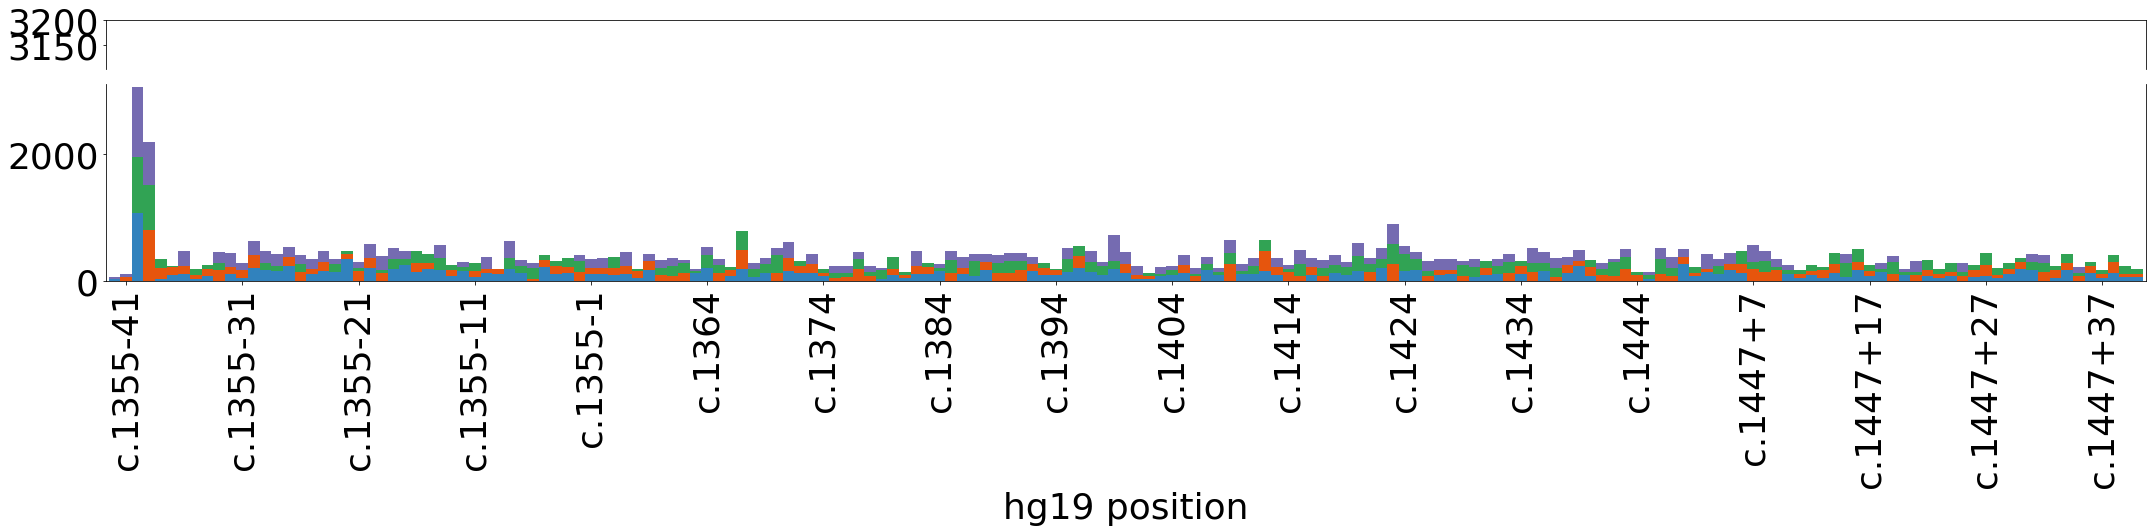

JKP1054


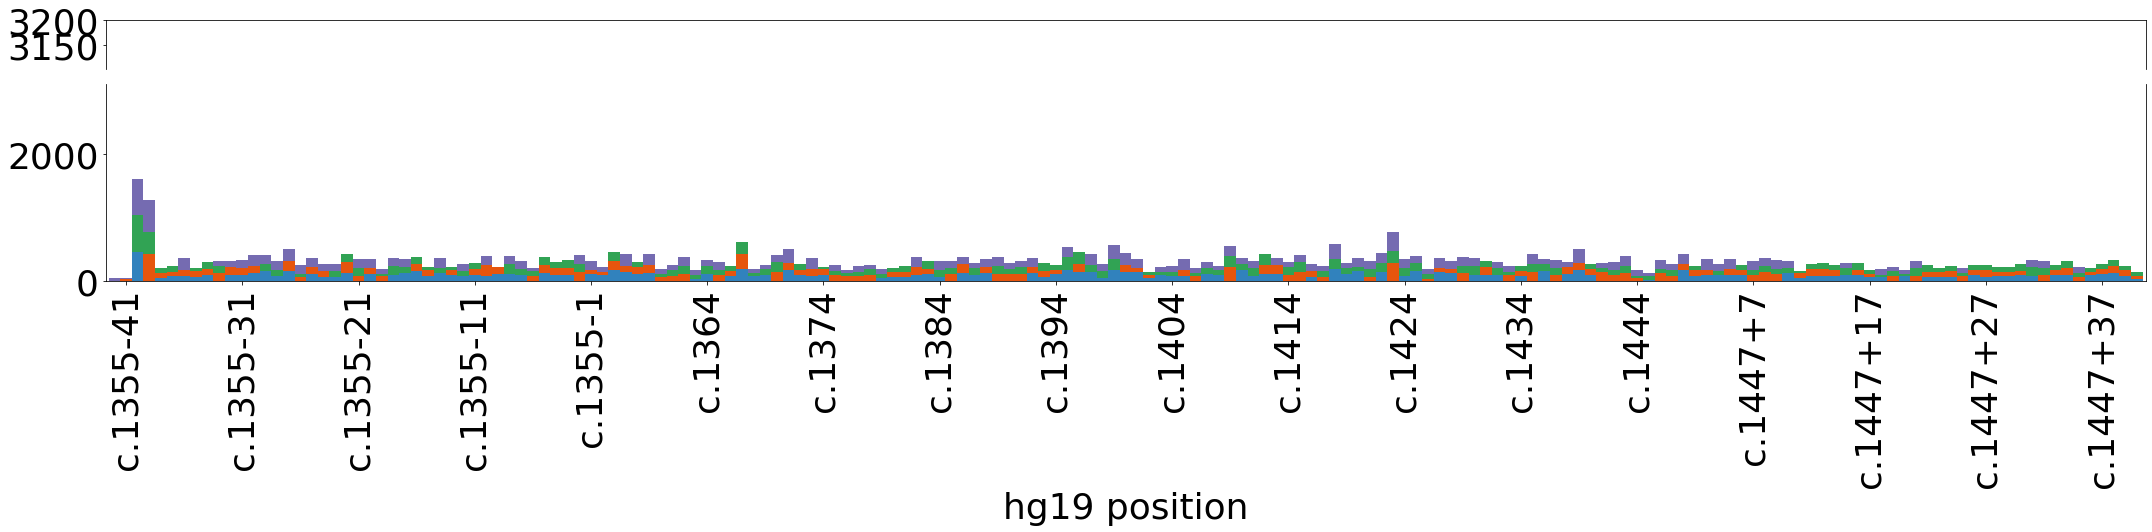

JKP1055


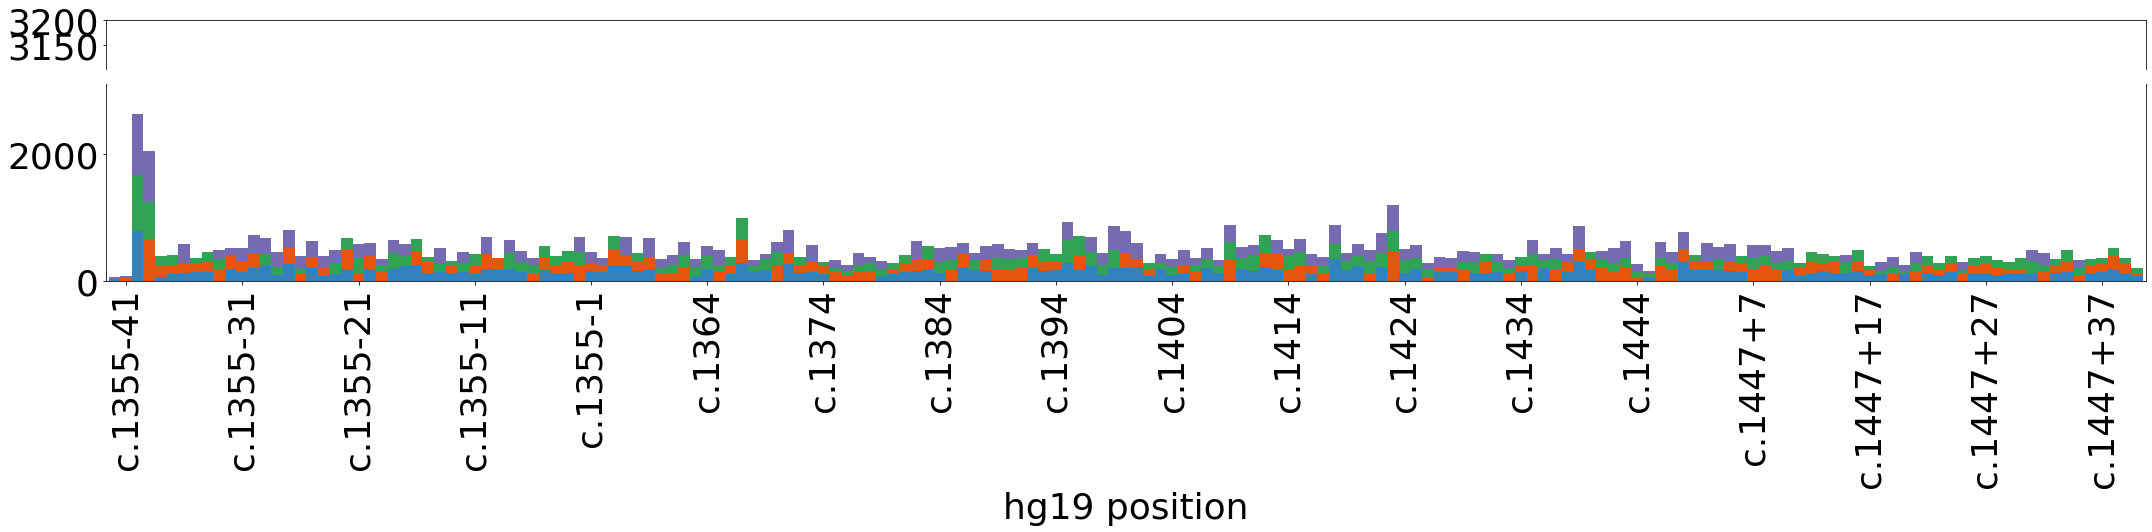

In [47]:
for name in sa_snvs_sat:
    
    print( name )
    
    sp.split_ax_bcs(  sa_snvs_sat[ name ].rename( columns = { 'alt': 'junk',
                                                              'ref': 'trash',
                                                              'alt_c': 'alt',
                                                              'ref_c': 'ref' } ),
                  [ 'n_bcs' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 3101, 3200 ), ( 0, 3100 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'hg19 position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

JKP1053


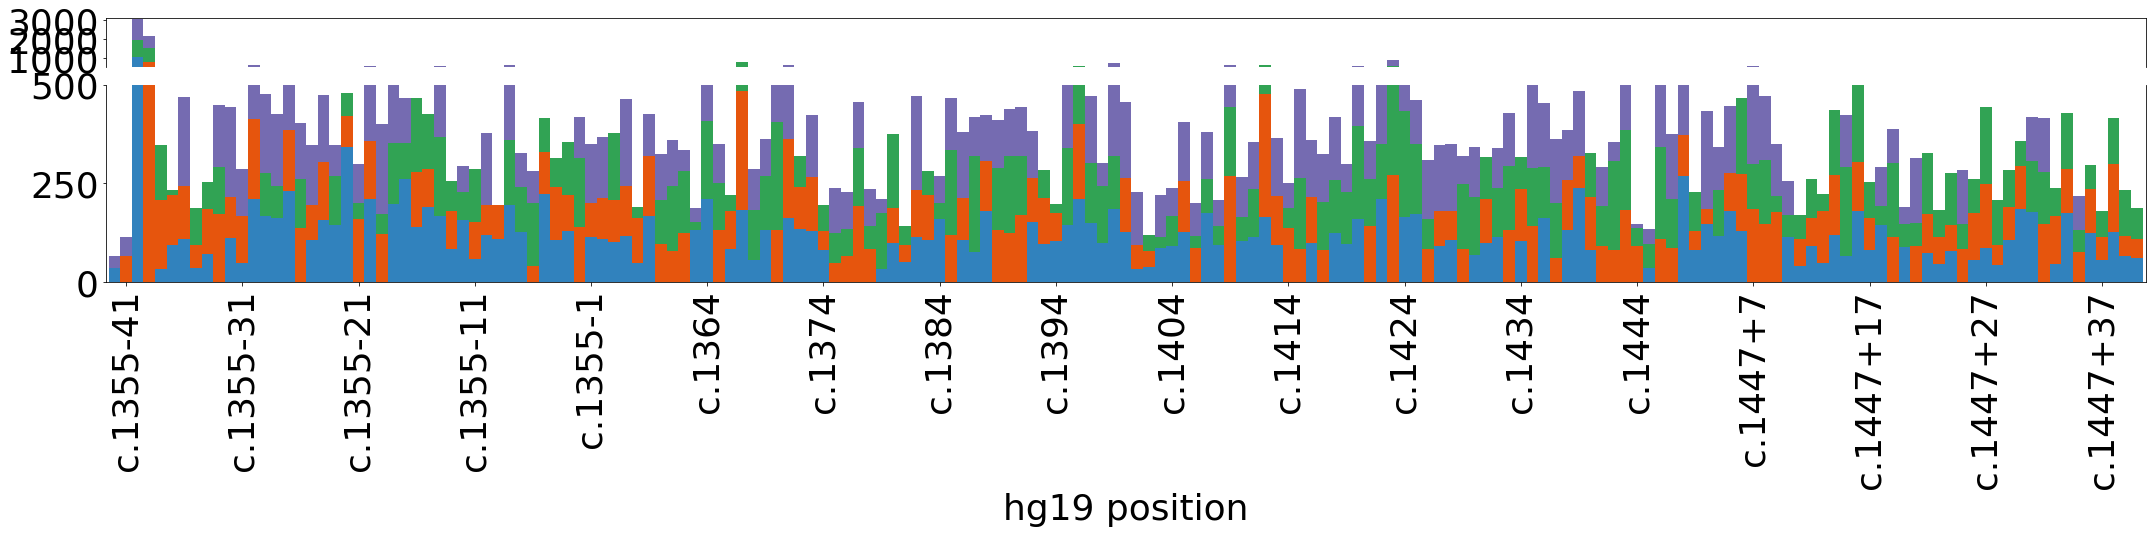

JKP1054


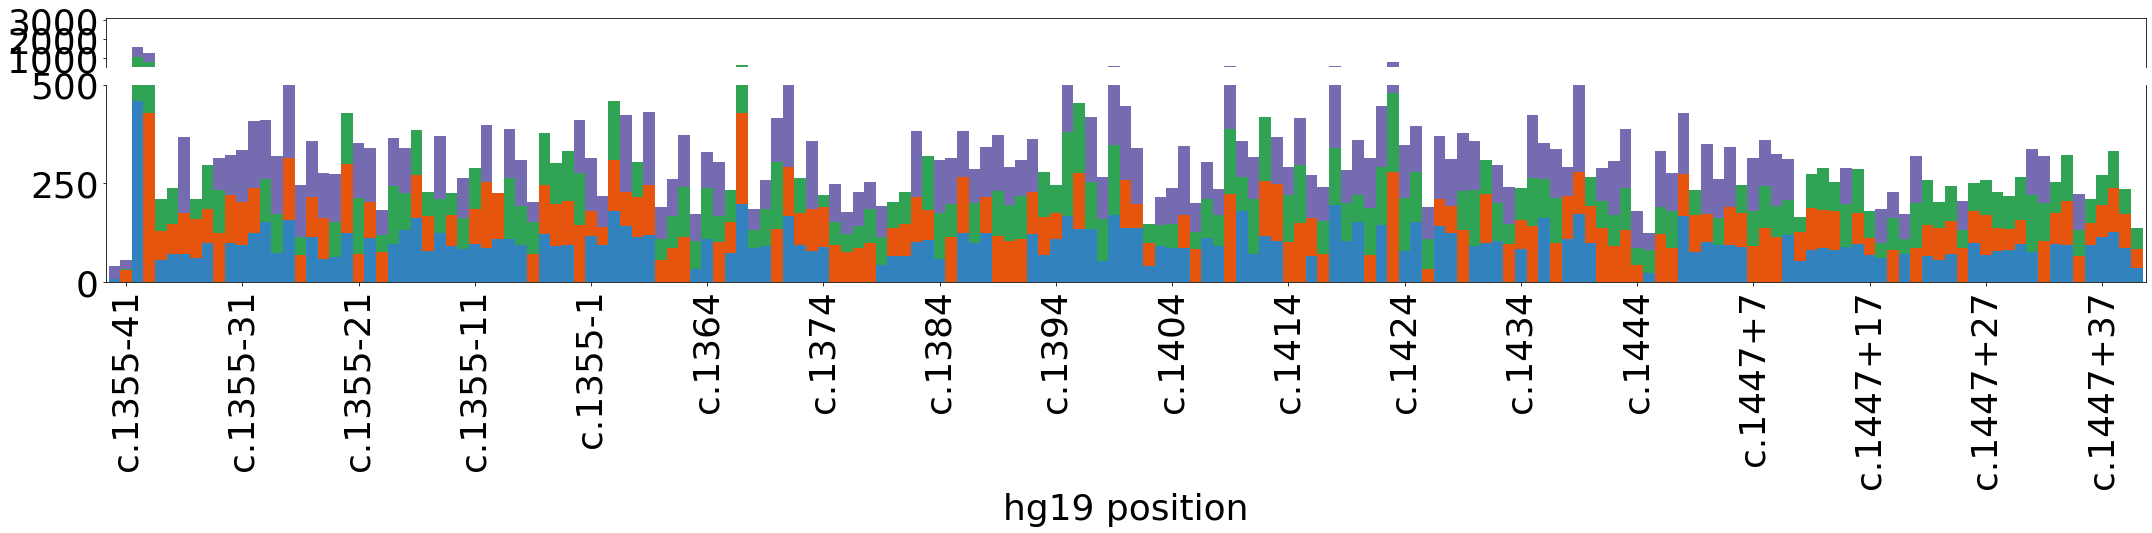

JKP1055


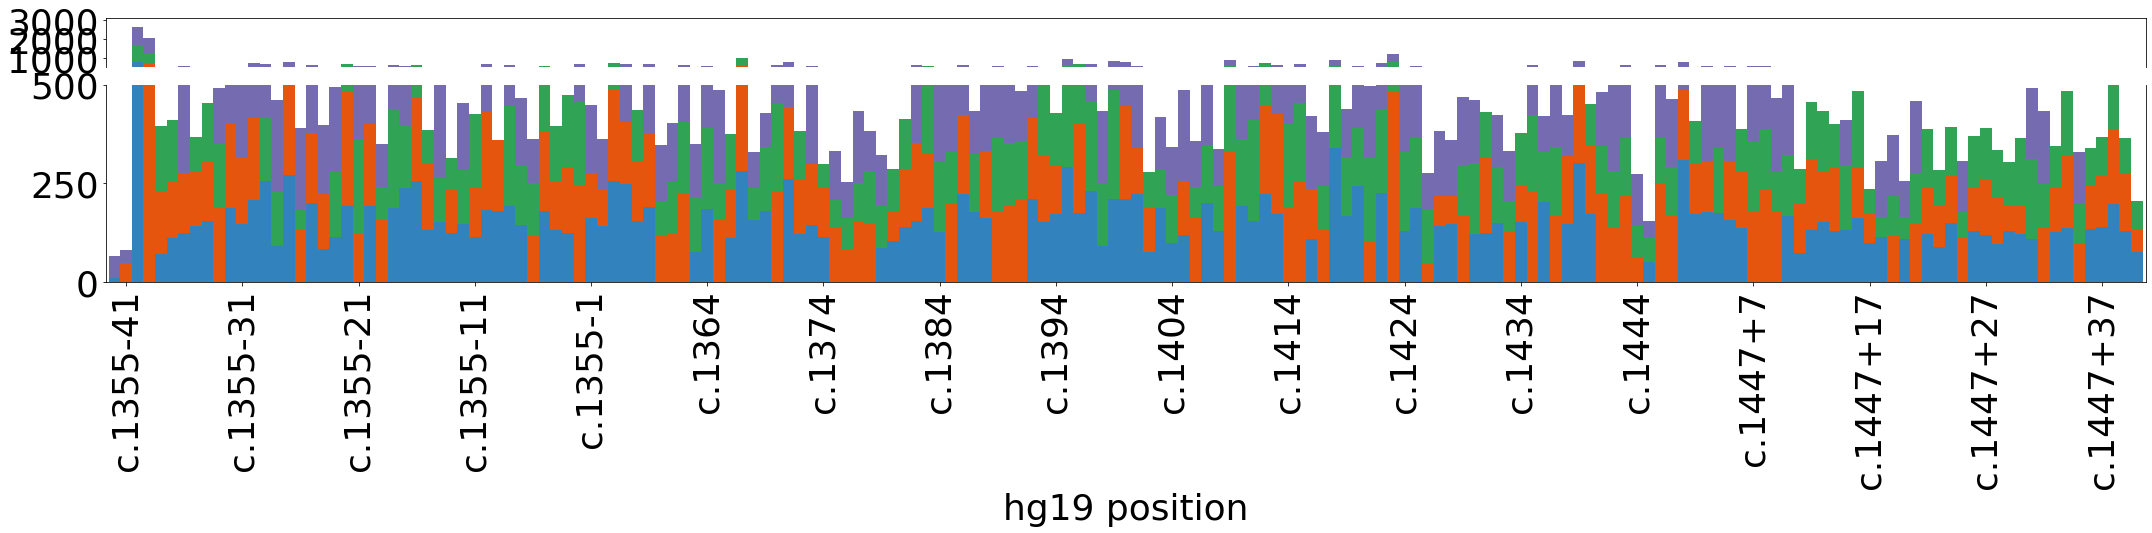

In [48]:
for name in sa_snvs_sat:
    
    print( name )
    
    sp.split_ax_bcs(  sa_snvs_sat[ name ].rename( columns = { 'alt': 'junk',
                                                              'ref': 'trash',
                                                              'alt_c': 'alt',
                                                              'ref_c': 'ref' } ),
                  [ 'n_bcs' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 501, 3100 ), ( 0, 500 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'hg19 position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

In [50]:
for name in sa_snvs_sat:
    
    print( name )
    
    print( len( sa_snvs_sat[ name ] ) )
    
    print( sa_snvs_sat[ name ].n_bcs.isnull().sum() )
    
    print( sa_snvs_sat[ name ].loc[ sa_snvs_sat[ name ].n_bcs.isnull() ] )
    
    print( 100*( sa_snvs_sat[ name ].n_bcs.notnull().sum() / len( sa_snvs_sat[ name ] ) ) )

JKP1053
525
2
     hg19_pos alt ref   pos exon_num   hgvs_pos  n_bcs ref_c alt_c
423  32413619   C   A  1258      NaN   c.1355-9    NaN     T     G
523  32413652   C   G  1225      NaN  c.1355-42    NaN     C     G
99.61904761904762
JKP1054
525
2
     hg19_pos alt ref   pos exon_num   hgvs_pos  n_bcs ref_c alt_c
423  32413619   C   A  1258      NaN   c.1355-9    NaN     T     G
523  32413652   C   G  1225      NaN  c.1355-42    NaN     C     G
99.61904761904762
JKP1055
525
2
     hg19_pos alt ref   pos exon_num   hgvs_pos  n_bcs ref_c alt_c
423  32413619   C   A  1258      NaN   c.1355-9    NaN     T     G
523  32413652   C   G  1225      NaN  c.1355-42    NaN     C     G
99.61904761904762
